In [47]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.ensemble import StackingRegressor

In [48]:
df_d = pd.read_pickle('Deals.pkl')
df_d.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21552 entries, 0 to 21593
Data columns (total 24 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Id                   21552 non-null  object        
 1   Deal Owner Name      21523 non-null  object        
 2   Closing Date         14629 non-null  datetime64[ns]
 3   Quality              19308 non-null  object        
 4   Stage                21551 non-null  object        
 5   Lost Reason          16097 non-null  object        
 6   Page                 21551 non-null  object        
 7   Campaign             21552 non-null  object        
 8   SLA                  15515 non-null  object        
 9   Content              14122 non-null  object        
 10  Term                 12442 non-null  object        
 11  Source               21551 non-null  object        
 12  Payment Type         492 non-null    object        
 13  Product              3589 non-null  

In [49]:
df_c = pd.read_pickle('Cals.pkl')
df_c.info()

<class 'pandas.core.frame.DataFrame'>
Index: 89487 entries, 0 to 95873
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   Id                          89487 non-null  object        
 1   Call Start Time             89487 non-null  datetime64[ns]
 2   Call Owner Name             89487 non-null  object        
 3   CONTACTID                   85811 non-null  object        
 4   Call Type                   89487 non-null  object        
 5   Call Duration (in seconds)  89412 non-null  float64       
 6   Call Status                 89487 non-null  object        
 7   Outgoing Call Status        80853 non-null  object        
 8   Scheduled in CRM            80853 non-null  object        
dtypes: datetime64[ns](1), float64(1), object(7)
memory usage: 6.8+ MB


In [50]:
df_c['Call Duration (in seconds)'].sum()

15720787.0

In [ ]:
# Calculate the total call duration in seconds
total_duration_seconds = df_c['Call Duration (in seconds)'].sum()

# Convert to hours and round to 2 decimal places
total_duration_hours = round(total_duration_seconds / 3600, 2)
print(f"Total call duration in hours: {total_duration_hours}")

# Group by manager and output data for all calls
df_grouped = df_c.groupby('Call Owner Name').agg(
    Call_Count_all=('CONTACTID', 'count'),  # Total number of calls
    Missed_Calls=('Call Type', lambda x: (x == 'Missed').sum())  # Number of missed calls
).reset_index()

# Rename columns without underscores
df_grouped.columns = ['Call Owner Name', 'Call Count All', 'Missed Calls']

# Filter calls that lasted more than 30 seconds
df_filtered = df_c[df_c['Call Duration (in seconds)'] > 30]

# Group by manager and output data for filtered calls
df_grouped_n = df_filtered.groupby('Call Owner Name').agg(
    Call_Count=('CONTACTID', 'count'),  # Number of calls > 30 seconds
    Total_Duration=('Call Duration (in seconds)', lambda x: (x.sum() / 3600).round(2))  # Total talk time in hours
).reset_index()

# Rename columns without underscores
df_grouped_n.columns = ['Call Owner Name', 'Call Count > 30s', 'Total Duration']

# Merge the two dataframes by manager
df_cc = pd.merge(df_grouped, df_grouped_n, on='Call Owner Name', how='left')

# Replace NaN values in 'Call Count > 30s' with 0 and convert to int
df_cc['Call Count > 30s'] = df_cc['Call Count > 30s'].fillna(0).astype(int)

# Output the result
df_cc.head()

# Calculate the sum for columns 'Call Count All', 'Call Count > 30s', 'Total Duration'
columns_to_sum = ['Call Count All', 'Call Count > 30s', 'Total Duration']

# Calculate the sum for each of the specified columns
sums_merged = df_cc[columns_to_sum].sum()

# Output results
print(sums_merged)

# Remove rows where Call Count is 0
df_ccf = df_cc[df_cc['Call Count All'] > 0].copy()

# Calculate average call duration per client
df_ccf['Dur per Client'] = (df_ccf['Total Duration'] / df_ccf['Call Count > 30s']).round(2)

# Calculate the percentage of missed calls
df_ccf['Missed Call %'] = ((df_ccf['Missed Calls'] / df_ccf['Call Count All']) * 100).round(2)

# Output the result
df_ccf.head()

Общая продолжительность звонков в часах: 4366.89
Call Count All      85811.00
Call Count > 30s    32789.00
Total Duration       4275.92
dtype: float64


,Call Owner Name,Call Count All,Missed Calls,Call Count > 30s,Total Duration,Dur per Client,Missed Call %
0,Alice Johnson,1213,3,315,37.82,0.12,0.25
1,Amy Green,5047,264,1649,149.47,0.09,5.23
2,Ben Hall,2683,0,954,198.61,0.21,0.00
3,Bob Brown,92,0,45,7.18,0.16,0.00
4,Cara Iverson,2776,0,916,137.10,0.15,0.00


In [ ]:
df_mk = pd.read_pickle('Менеджер-косяк.pkl')
df_mk.info()

<class 'pandas.core.frame.DataFrame'>
Index: 44 entries, 454 to 18747
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Id                   44 non-null     object        
 1   Created Time         44 non-null     datetime64[ns]
 2   Closing Date         44 non-null     datetime64[ns]
 3   Deal Owner Name      43 non-null     object        
 4   Course duration      7 non-null      float64       
 5   Months of study      3 non-null      float64       
 6   Initial Amount Paid  8 non-null      object        
 7   Offer Total Amount   8 non-null      object        
 8   Product              7 non-null      object        
 9   Stage                44 non-null     object        
dtypes: datetime64[ns](2), float64(2), object(6)
memory usage: 3.8+ KB


In [ ]:
# Group data by Deal Owner Name and count records by Id field
df_aggregated = df_mk.groupby('Deal Owner Name').agg(
    Number_of_Mistakes=('Id', 'count')  # Count by Id field
).reset_index()

# Rename the column to English
df_aggregated.columns = ['Deal Owner Name', 'Number of Mistakes']

# Output the result
df_aggregated

,Deal Owner Name,Number of Mistakes
0,Ben Hall,1
1,Cara Iverson,3
2,Charlie Davis,6
3,Diana Evans,1
4,Ian Miller,1
5,Julia Nelson,5
6,Nina Scott,1
7,Oliver Taylor,2
8,Paula Underwood,6
9,Quincy Vincent,6


In [ ]:
# Merge df_ccf and df_aggregated on Call Owner Name and Deal Owner Name using outer method
df_ccfk = pd.merge(df_ccf, df_aggregated, left_on='Call Owner Name', right_on='Deal Owner Name', how='outer')

# Remove the duplicate column 'Deal Owner Name' after merging
df_ccfk = df_ccfk.drop(columns=['Deal Owner Name'])

# Replace missing values in the 'Number of Mistakes' column with 0 and convert to int
df_ccfk['Number of Mistakes'] = df_ccfk['Number of Mistakes'].fillna(0).astype(int)

# Output only the necessary columns
df_ccfk = df_ccfk[['Call Owner Name', 'Call Count All', 'Call Count > 30s', 'Total Duration', 
                   'Missed Calls', 'Dur per Client', 'Missed Call %', 'Number of Mistakes']]

# Output the result
df_ccfk

,Call Owner Name,Call Count All,Call Count > 30s,Total Duration,Missed Calls,Dur per Client,Missed Call %,Number of Mistakes
0,Alice Johnson,1213,315,37.82,3,0.12,0.25,0
1,Amy Green,5047,1649,149.47,264,0.09,5.23,0
2,Ben Hall,2683,954,198.61,0,0.21,0.00,1
3,Bob Brown,92,45,7.18,0,0.16,0.00,0
4,Cara Iverson,2776,916,137.10,0,0.15,0.00,3
5,Charlie Davis,6359,2433,426.94,587,0.18,9.23,6
6,Derek James,849,531,50.15,0,0.09,0.00,0
7,Diana Evans,6392,2216,342.69,314,0.15,4.91,1
8,Ethan Harris,268,110,3.57,3,0.03,1.12,0
9,Eva Kent,474,187,54.83,5,0.29,1.05,0


In [55]:
df_d = pd.read_pickle('Deals.pkl')
df_d.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21552 entries, 0 to 21593
Data columns (total 24 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Id                   21552 non-null  object        
 1   Deal Owner Name      21523 non-null  object        
 2   Closing Date         14629 non-null  datetime64[ns]
 3   Quality              19308 non-null  object        
 4   Stage                21551 non-null  object        
 5   Lost Reason          16097 non-null  object        
 6   Page                 21551 non-null  object        
 7   Campaign             21552 non-null  object        
 8   SLA                  15515 non-null  object        
 9   Content              14122 non-null  object        
 10  Term                 12442 non-null  object        
 11  Source               21551 non-null  object        
 12  Payment Type         492 non-null    object        
 13  Product              3589 non-null  

In [ ]:
# Convert 'Initial Amount Paid' and 'Offer Total Amount' to float type
df_d['Initial Amount Paid'] = pd.to_numeric(df_d['Initial Amount Paid'], errors='coerce')
df_d['Offer Total Amount'] = pd.to_numeric(df_d['Offer Total Amount'], errors='coerce')

# Add a new column 'Sum_Paid', initialized to zero with float type
df_d['Sum_Paid'] = 0.0

# Apply conditions: Stage = 'Payment Done', Offer Total Amount > 0, Months of study > 0
condition = (df_d['Stage'] == 'Payment Done') & (df_d['Offer Total Amount'] > 0) & (df_d['Months of study'] > 0)

# Calculate 'Sum_Paid' using the formula for rows that meet the conditions
df_d.loc[condition, 'Sum_Paid'] = (df_d['Offer Total Amount'] / df_d['Course duration'] * df_d['Months of study']).astype(float)

# Check the result
df_d[['Id', 'Stage', 'Offer Total Amount', 'Months of study', 'Course duration', 'Sum_Paid']].head()

,Id,Stage,Offer Total Amount,Months of study,Course duration,Sum_Paid
0,5805028000056864768,New Lead,NaN,NaN,NaN,0.0
1,5805028000056859648,New Lead,2000.0,NaN,6.0,0.0
2,5805028000056832000,Lost,NaN,NaN,NaN,0.0
3,5805028000056823808,Lost,NaN,NaN,NaN,0.0
4,5805028000056873984,Lost,NaN,NaN,NaN,0.0


In [ ]:
# Group data by campaigns and count leads and clients
df_grouped_f = df_d.groupby('Deal Owner Name').agg(
    Leads=('Id', 'count'),  # Total number of deals
    Clients=('Stage', lambda x: ((x == 'Payment Done') & (df_d.loc[x.index, 'Months of study'] > 0)).sum()),  # Number of clients considering the condition
    Sum_Paid=('Sum_Paid', 'sum')  # Sum in the Sum_Paid column
).reset_index()  # Reset index so 'Deal Owner Name' is not the index

# Round the sum after aggregation
df_grouped_f['Sum_Paid'] = df_grouped_f['Sum_Paid'].round(2)

# Calculate conversion rate percentage
df_grouped_f['Convers Rate %'] = ((df_grouped_f['Clients'] / df_grouped_f['Leads']) * 100).round(2)

# Output the result
df_grouped_f.head()

,Deal Owner Name,Leads,Clients,Sum_Paid,Convers Rate %
0,Alice Johnson,25,0,0.00,0.00
1,Amy Green,66,0,0.00,0.00
2,Ben Hall,1345,46,99825.76,3.42
3,Bob Brown,331,0,0.00,0.00
4,Cara Iverson,1056,27,49242.42,2.56


In [ ]:
# Calculate the sum for the columns Clients and Sum_Paid
clients_sum = df_grouped_f['Clients'].sum()
sum_paid_sum = df_grouped_f['Sum_Paid'].sum()
leads_sum = df_grouped_f['Leads'].sum()

# Output the results
print(f"Total number of clients (Clients): {clients_sum}")
print(f"Total Sum_Paid: {sum_paid_sum}")
print(f"Total number of leads (Leads): {leads_sum}")

Сумма клиентов (Clients): 838
Сумма Sum_Paid: 3340287.8800000004
Сумма клиентов (Clients): 21523


In [ ]:
# Merge df_ccf and df_grouped_f on Call Owner Name and Deal Owner Name using outer method
df_ccfkf = pd.merge(df_ccfk, df_grouped_f, left_on='Call Owner Name', right_on='Deal Owner Name', how='outer')

# Replace missing values in numeric columns with 0 and convert them to the required types
df_ccfkf[['Leads', 'Clients', 'Sum_Paid']] = df_ccfkf[['Leads', 'Clients', 'Sum_Paid']].fillna(0).astype(float)

# Remove the duplicate column 'Deal Owner Name' after merging
df_ccfkf = df_ccfkf.drop(columns=['Deal Owner Name'])

# Keep only the necessary columns for output
df_ccfkf = df_ccfkf[['Call Owner Name', 'Call Count All', 'Call Count > 30s', 'Total Duration', 'Missed Calls', 
                     'Dur per Client', 'Missed Call %', 'Number of Mistakes', 'Leads', 'Clients', 'Sum_Paid', 
                     'Convers Rate %']]

# Output the result
df_ccfkf.head()

,Call Owner Name,Call Count All,Call Count > 30s,Total Duration,Missed Calls,Dur per Client,Missed Call %,Number of Mistakes,Leads,Clients,Sum_Paid,Convers Rate %
0,Alice Johnson,1213,315,37.82,3,0.12,0.25,0,25.0,0.0,0.00,0.00
1,Amy Green,5047,1649,149.47,264,0.09,5.23,0,66.0,0.0,0.00,0.00
2,Ben Hall,2683,954,198.61,0,0.21,0.00,1,1345.0,46.0,99825.76,3.42
3,Bob Brown,92,45,7.18,0,0.16,0.00,0,331.0,0.0,0.00,0.00
4,Cara Iverson,2776,916,137.10,0,0.15,0.00,3,1056.0,27.0,49242.42,2.56


In [ ]:
# Calculate the sum for the columns
call_count_all_sum = df_ccfkf['Call Count All'].sum()
call_count_over_30s_sum = df_ccfkf['Call Count > 30s'].sum()
total_duration_sum = df_ccfkf['Total Duration'].sum()
leads_sum = df_ccfkf['Leads'].sum()
clients_sum = df_ccfkf['Clients'].sum()
sum_paid_sum = df_ccfkf['Sum_Paid'].sum()

# Output the results
print(f"Total number of calls (Call Count All): {call_count_all_sum}")
print(f"Total number of calls > 30 seconds (Call Count > 30s): {call_count_over_30s_sum}")
print(f"Total duration of calls (Total Duration): {total_duration_sum}")
print(f"Total number of leads (Leads): {leads_sum}")
print(f"Total number of clients (Clients): {clients_sum}")
print(f"Total Sum_Paid: {sum_paid_sum}")

Сумма всех звонков (Call Count All): 85811
Сумма звонков > 30 секунд (Call Count > 30s): 32789
Суммарная продолжительность звонков (Total Duration): 4275.74
Сумма лидов (Leads): 21523.0
Сумма клиентов (Clients): 838.0
Сумма Sum_Paid: 3340287.88


In [ ]:
# Set the end date (03.07.2024)
end_date = pd.to_datetime('2024-07-03')

# Calculate the number of months for each call
df_c['Months Worked'] = ((end_date - df_c['Call Start Time']).dt.days / 30).round(2)

# Group data by managers and select the maximum number of months for each manager
df_months_worked = df_c.groupby('Call Owner Name').agg({'Months Worked': 'max'}).reset_index()

# Rename the column without an underscore
df_months_worked = df_months_worked.rename(columns={'Months Worked': 'Months Worked'})

# Merge the data with the main table by managers
df_final = pd.merge(df_ccfkf, df_months_worked, on='Call Owner Name', how='left')

# Fill missing values with 0 in a correct way
df_final['Months Worked'] = df_final['Months Worked'].fillna(0)

# Output the result
df_final[['Call Owner Name', 'Call Count All', 'Call Count > 30s', 'Total Duration', 'Missed Calls', 
                     'Dur per Client', 'Missed Call %', 'Number of Mistakes', 'Leads', 'Clients', 'Sum_Paid', 
                     'Convers Rate %', 'Months Worked']]

,Call Owner Name,Call Count All,Call Count > 30s,Total Duration,Missed Calls,Dur per Client,Missed Call %,Number of Mistakes,Leads,Clients,Sum_Paid,Convers Rate %,Months Worked
0,Alice Johnson,1213,315,37.82,3,0.12,0.25,0,25.0,0.0,0.00,0.00,12.10
1,Amy Green,5047,1649,149.47,264,0.09,5.23,0,66.0,0.0,0.00,0.00,5.33
2,Ben Hall,2683,954,198.61,0,0.21,0.00,1,1345.0,46.0,99825.76,3.42,5.07
3,Bob Brown,92,45,7.18,0,0.16,0.00,0,331.0,0.0,0.00,0.00,12.07
4,Cara Iverson,2776,916,137.10,0,0.15,0.00,3,1056.0,27.0,49242.42,2.56,3.73
5,Charlie Davis,6359,2433,426.94,587,0.18,9.23,6,2958.0,147.0,576496.97,4.97,11.30
6,Derek James,849,531,50.15,0,0.09,0.00,0,0.0,0.0,0.00,NaN,2.93
7,Diana Evans,6392,2216,342.69,314,0.15,4.91,1,1011.0,1.0,3500.00,0.10,11.20
8,Ethan Harris,268,110,3.57,3,0.03,1.12,0,0.0,0.0,0.00,NaN,10.60
9,Eva Kent,474,187,54.83,5,0.29,1.05,0,459.0,18.0,20498.48,3.92,1.87


In [ ]:
# Calculate the sum for the columns
call_count_all_sum = df_final['Call Count All'].sum()
call_count_over_30s_sum = df_final['Call Count > 30s'].sum()
total_duration_sum = df_final['Total Duration'].sum()
leads_sum = df_final['Leads'].sum()
clients_sum = df_final['Clients'].sum()
sum_paid_sum = df_final['Sum_Paid'].sum()

# Output the results
print(f"Total number of calls (Call Count All): {call_count_all_sum}")
print(f"Total number of calls > 30 seconds (Call Count > 30s): {call_count_over_30s_sum}")
print(f"Total duration of calls (Total Duration): {total_duration_sum}")
print(f"Total number of leads (Leads): {leads_sum}")
print(f"Total number of clients (Clients): {clients_sum}")
print(f"Total Sum_Paid: {sum_paid_sum}")

Сумма всех звонков (Call Count All): 85811
Сумма звонков > 30 секунд (Call Count > 30s): 32789
Суммарная продолжительность звонков (Total Duration): 4275.74
Сумма лидов (Leads): 21523.0
Сумма клиентов (Clients): 838.0
Сумма Sum_Paid: 3340287.88


In [ ]:
# Create a copy of the original data to avoid changing the original table
df_per_month = df_final.copy()

# List of columns to divide by the number of months
columns_to_divide = ['Call Count All', 'Call Count > 30s', 'Total Duration', 'Missed Calls', 
                     'Number of Mistakes', 'Leads', 'Clients', 'Sum_Paid', 'Convers Rate %']

# Apply division for each column
for col in columns_to_divide:
    df_per_month[col + ' (м)'] = (df_per_month[col] / df_per_month['Months Worked']).round(2)

# Move the 'Missed Call %' column after 'Missed Calls (м)'
df_per_month = df_per_month[['Call Owner Name'] + 
                            [col + ' (м)' for col in columns_to_divide[:4]] + 
                            ['Missed Call %'] + 
                            [col + ' (м)' for col in columns_to_divide[4:]] + 
                            ['Dur per Client']]

# Keep only the necessary columns
df_result_m = df_per_month[['Call Owner Name'] + 
                         [col + ' (м)' for col in ['Call Count All', 'Call Count > 30s', 'Total Duration', 'Missed Calls']] + 
                         ['Missed Call %'] + 
                         [col + ' (м)' for col in ['Number of Mistakes', 'Leads', 'Clients', 'Convers Rate %', 'Sum_Paid']] + 
                         ['Dur per Client']]

# Output the result
df_result_m.head()

,Call Owner Name,Call Count All (м),Call Count > 30s (м),Total Duration (м),Missed Calls (м),Missed Call %,Number of Mistakes (м),Leads (м),Clients (м),Convers Rate % (м),Sum_Paid (м),Dur per Client
0,Alice Johnson,100.25,26.03,3.13,0.25,0.25,0.0,2.07,0.00,0.00,0.00,0.12
1,Amy Green,946.90,309.38,28.04,49.53,5.23,0.0,12.38,0.00,0.00,0.00,0.09
2,Ben Hall,529.19,188.17,39.17,0.00,0.00,0.2,265.29,9.07,0.67,19689.50,0.21
3,Bob Brown,7.62,3.73,0.59,0.00,0.00,0.0,27.42,0.00,0.00,0.00,0.16
4,Cara Iverson,744.24,245.58,36.76,0.00,0.00,0.8,283.11,7.24,0.69,13201.72,0.15


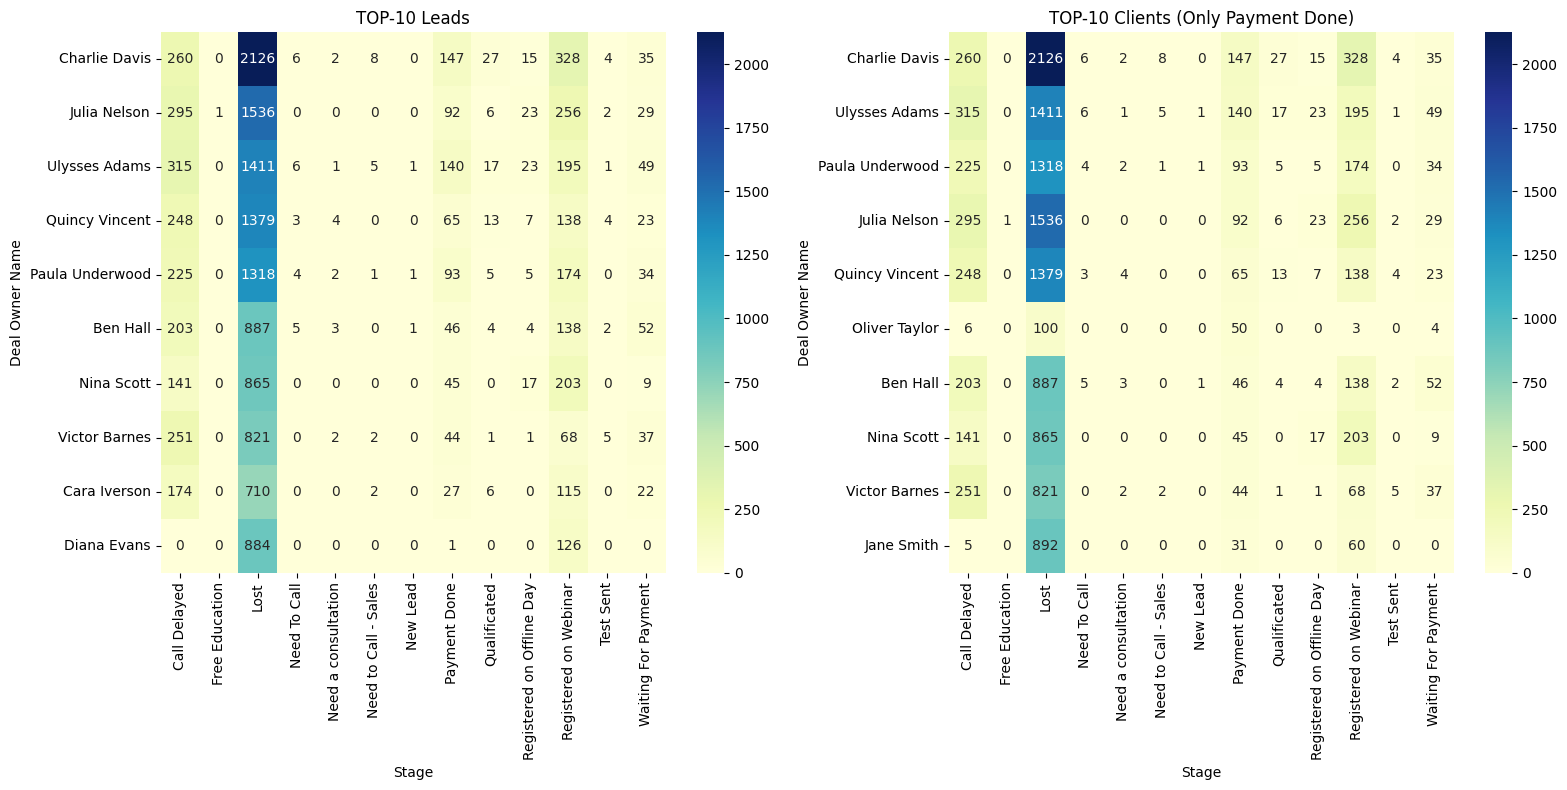

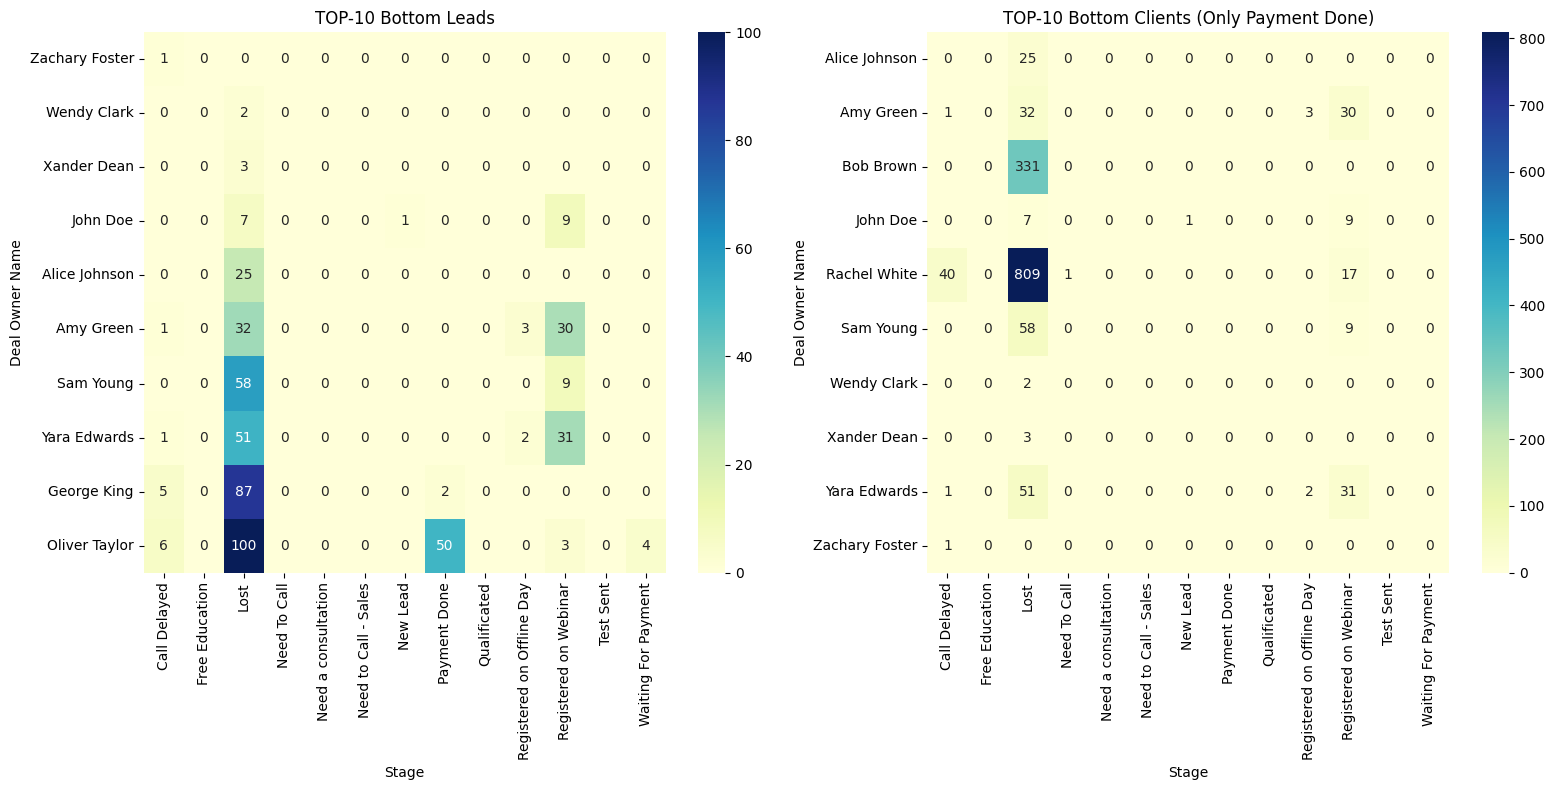

In [ ]:
# Grouping data by managers and stages
df_grouped_stage = df_d.groupby(['Deal Owner Name', 'Stage']).size().unstack(fill_value=0)

# Counting the number of leads (all deals) and clients (deals at the 'Payment Done' stage)
df_leads = df_grouped_stage.sum(axis=1)  # Number of leads (all deals)
df_clients = df_grouped_stage['Payment Done']  # Number of clients (only successful deals)

# Top-10 best and worst by leads and clients
top_10_leads = df_leads.nlargest(10).index
top_10_clients = df_clients.nlargest(10).index
bottom_10_leads = df_leads.nsmallest(10).index
bottom_10_clients = df_clients.nsmallest(10).index

# Function to plot heatmaps
def plot_top_bottom_heatmaps(top_leads, top_clients, title_leads, title_clients):
    fig, axes = plt.subplots(1, 2, figsize=(16, 8))

    # Top-10 best by leads
    sns.heatmap(df_grouped_stage.loc[top_leads], cmap="YlGnBu", annot=True, fmt='d', ax=axes[0])
    axes[0].set_title(title_leads)
    axes[0].set_xlabel('Stage')
    axes[0].set_ylabel('Deal Owner Name')

    # Top-10 best by clients
    sns.heatmap(df_grouped_stage.loc[top_clients], cmap="YlGnBu", annot=True, fmt='d', ax=axes[1])
    axes[1].set_title(title_clients)
    axes[1].set_xlabel('Stage')
    axes[1].set_ylabel('Deal Owner Name')

    plt.tight_layout()
    plt.show()

# Visualization of the top-10 best managers by leads and clients
plot_top_bottom_heatmaps(top_10_leads, top_10_clients, 'TOP-10 Leads', 'TOP-10 Clients (Only Payment Done)')

# Visualization of the top-10 worst managers by leads and clients
plot_top_bottom_heatmaps(bottom_10_leads, bottom_10_clients, 'TOP-10 Bottom Leads', 'TOP-10 Bottom Clients (Only Payment Done)')

In [ ]:
# Creating a copy of the data for analysis
df_rating = df_result_m.copy()

# Defining features for the model based on the correlation matrix
features = df_rating[['Total Duration (м)', 'Leads (м)', 'Sum_Paid (м)', 'Clients (м)', 'Number of Mistakes (м)', 'Missed Calls (м)']]

# Defining the target variable — 'Clients (м)'
target = df_rating['Sum_Paid (м)']

# Filling missing values with the median
features = features.fillna(features.median())
target = target.fillna(target.median())

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Scaling the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Creating a model (for example, GradientBoostingRegressor)
gbr_model = GradientBoostingRegressor(n_estimators=100, random_state=42)

# Training the model
gbr_model.fit(X_train_scaled, y_train)

# Making predictions on the test set
y_pred = gbr_model.predict(X_test_scaled)

# Evaluating the model's accuracy
accuracy = r2_score(y_test, y_pred)
print(f'Gradient Boosting Model Accuracy (R² score): {accuracy:.2f}')

# Feature importances
feature_importances = gbr_model.feature_importances_

# Outputting feature importances
print("Feature Importances:")
for feature, importance in zip(features.columns, feature_importances):
    print(f"{feature}: {importance:.4f}")

# Now we can use the model to predict ratings for all managers
df_rating['Predict rating'] = gbr_model.predict(scaler.transform(features)).round(2)

# Sorting managers by predicted rating
df_merged_sorted = df_rating.sort_values(by='Predict rating', ascending=False)

# Outputting the top rows with predicted ratings (top managers)
print("Top 10 Managers by Predict Rating:")
df_merged_sorted.head(10)

Gradient Boosting Model Accuracy (R² score): 0.98
Feature Importances:
Total Duration (м): 0.0352
Leads (м): 0.0323
Sum_Paid (м): 0.8899
Clients (м): 0.0424
Number of Mistakes (м): 0.0002
Missed Calls (м): 0.0000
Top 10 Managers by Predict Rating:


,Call Owner Name,Call Count All (м),Call Count > 30s (м),Total Duration (м),Missed Calls (м),Missed Call %,Number of Mistakes (м),Leads (м),Clients (м),Convers Rate % (м),Sum_Paid (м),Dur per Client,Predict rating
26,Ulysses Adams,858.08,327.16,52.55,47.25,5.51,0.78,339.72,21.98,1.02,84166.55,0.16,84164.72
20,Oliver Taylor,1.07,0.27,0.03,0.00,0.00,0.27,21.82,6.69,4.11,51332.60,0.13,51331.17
5,Charlie Davis,562.74,215.31,37.78,51.95,9.23,0.53,261.77,13.01,0.44,51017.43,0.18,51016.39
16,Julia Nelson,689.05,259.88,41.93,40.23,5.84,0.51,229.27,9.42,0.42,44811.58,0.16,44810.79
21,Paula Underwood,573.90,208.03,32.65,34.27,5.97,0.80,249.26,12.45,0.67,41962.80,0.16,41962.23
22,Quincy Vincent,549.17,207.92,44.96,30.00,5.46,0.83,261.67,9.03,0.48,29815.87,0.22,29815.48
27,Victor Barnes,855.67,512.67,34.80,3.67,0.43,0.33,205.33,7.33,0.60,27071.46,0.07,27071.16
19,Nina Scott,628.96,243.25,24.70,61.69,9.81,0.13,166.23,5.84,0.46,22765.05,0.10,22764.90
2,Ben Hall,529.19,188.17,39.17,0.00,0.00,0.20,265.29,9.07,0.67,19689.50,0.21,19689.48
14,Jane Smith,262.37,94.49,16.66,24.57,9.36,0.00,81.18,2.55,0.26,14476.73,0.18,14476.80


In [ ]:
# Output the last rows (worst managers)
print("Bottom 10 Managers by Predict Rating:")
df_merged_sorted.tail(10)

Bottom 10 Managers by Predict Rating:


,Call Owner Name,Call Count All (м),Call Count > 30s (м),Total Duration (м),Missed Calls (м),Missed Call %,Number of Mistakes (м),Leads (м),Clients (м),Convers Rate % (м),Sum_Paid (м),Dur per Client,Predict rating
29,Xander Dean,50.09,19.36,1.52,0.00,0.00,0.0,0.53,0.0,0.0,0.0,0.08,0.5
0,Alice Johnson,100.25,26.03,3.13,0.25,0.25,0.0,2.07,0.0,0.0,0.0,0.12,0.5
1,Amy Green,946.90,309.38,28.04,49.53,5.23,0.0,12.38,0.0,0.0,0.0,0.09,0.5
15,John Doe,203.42,81.66,8.35,93.48,45.95,0.0,1.39,0.0,0.0,0.0,0.10,0.5
12,Hannah Lee,17.71,7.16,0.28,1.74,9.83,0.0,0.00,0.0,NaN,0.0,0.04,0.5
10,Fiona Jackson,37.82,3.44,0.33,34.00,89.90,0.0,0.00,0.0,NaN,0.0,0.10,0.5
8,Ethan Harris,25.28,10.38,0.34,0.28,1.12,0.0,0.00,0.0,NaN,0.0,0.03,0.5
6,Derek James,289.76,181.23,17.12,0.00,0.00,0.0,0.00,0.0,NaN,0.0,0.09,0.5
3,Bob Brown,7.62,3.73,0.59,0.00,0.00,0.0,27.42,0.0,0.0,0.0,0.16,0.5
31,Zachary Foster,93.25,29.08,2.51,3.38,3.62,0.0,0.19,0.0,0.0,0.0,0.09,0.5


In [67]:
df_merged_sorted.to_pickle('Manager_sum.pkl')

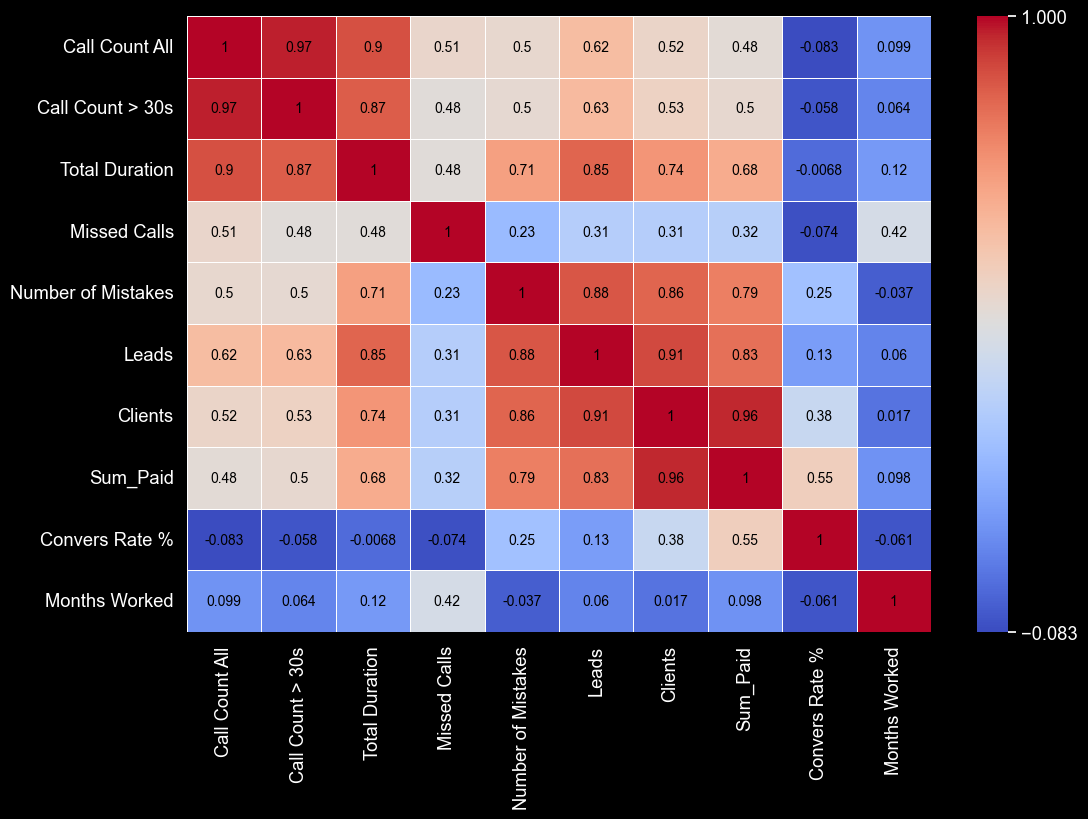

In [ ]:
# Visualize the correlation matrix with a dynamic gradient scale
plt.figure(figsize=(12, 8), facecolor='black')
sns.set(font_scale=1.2)

# Build the heatmap without a strict specification of vmin and vmax, so that real min/max values are used
heatmap = sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5, 
                      annot_kws={"size": 10, "color": "black"},  # Text color inside the matrix
                      cbar_kws={"ticks": [-1, -0.5, 0, 0.5, 1]})  # Legend

# Set the background to black
heatmap.set_facecolor("black")

# Set the text color on the axes
heatmap.xaxis.label.set_color('white')
heatmap.yaxis.label.set_color('white')
heatmap.tick_params(colors='white')  # White ticks on the axes

# Configure the color scale (gradient and tick labels on the legend)
colorbar = heatmap.collections[0].colorbar
colorbar.set_ticks([correlation_matrix.min().min(), correlation_matrix.max().max()])  # Dynamic specification of min/max values
colorbar.ax.yaxis.set_tick_params(color='white')
plt.setp(colorbar.ax.yaxis.get_majorticklabels(), color='white')

# Title in white color
plt.show()

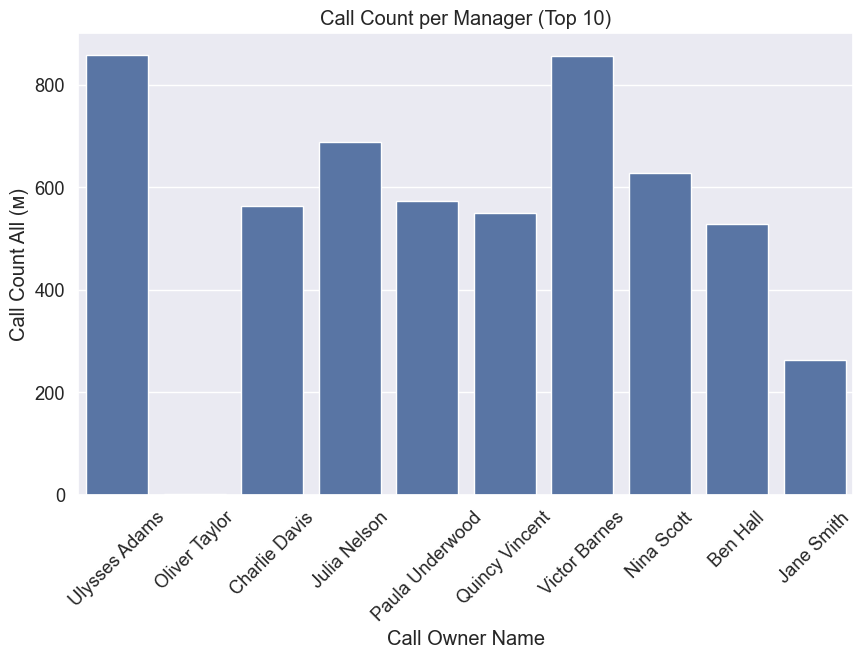

In [ ]:
# Create a histogram to analyze the number of calls
plt.figure(figsize=(10, 6))
sns.barplot(x='Call Owner Name', y='Call Count All (м)', data=df_merged_sorted.head(10))
plt.title('Call Count per Manager (Top 10)')
plt.xticks(rotation=45)
plt.show()

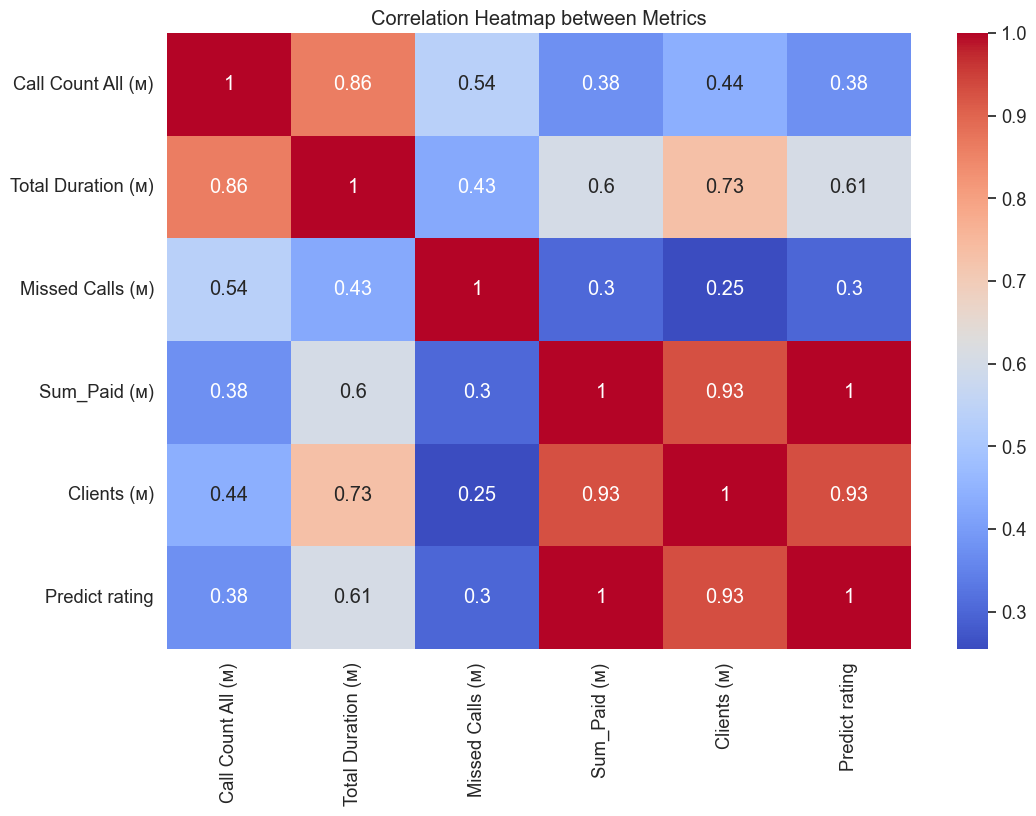

In [70]:
plt.figure(figsize=(12, 8))
sns.heatmap(df_merged_sorted[['Call Count All (м)', 'Total Duration (м)', 'Missed Calls (м)', 'Sum_Paid (м)', 'Clients (м)', 'Predict rating']].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap between Metrics')
plt.show()

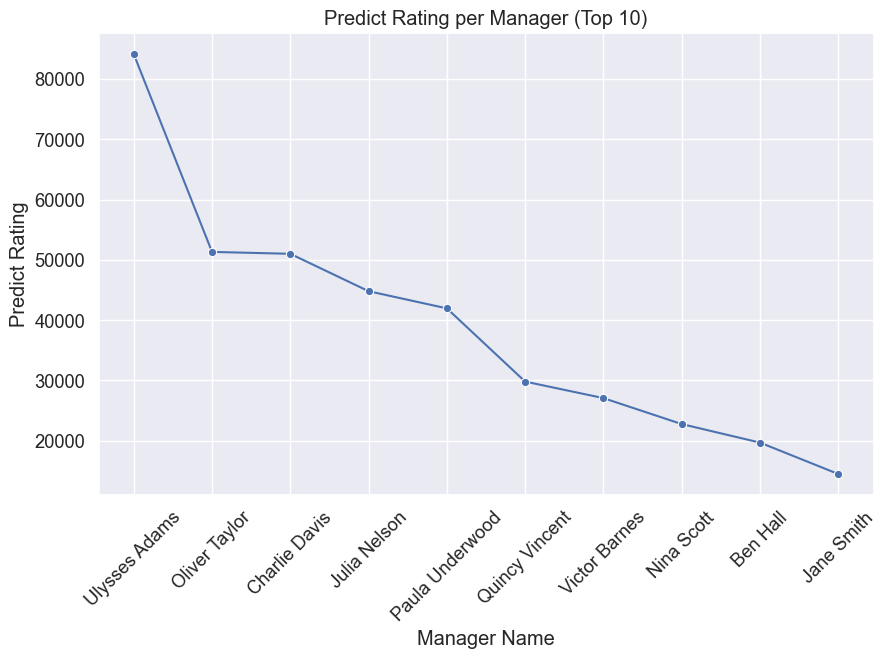

In [71]:
plt.figure(figsize=(10, 6))
sns.lineplot(x='Call Owner Name', y='Predict rating', data=df_merged_sorted.head(10), marker='o')
plt.title('Predict Rating per Manager (Top 10)')
plt.xticks(rotation=45)
plt.ylabel('Predict Rating')
plt.xlabel('Manager Name')
plt.show()

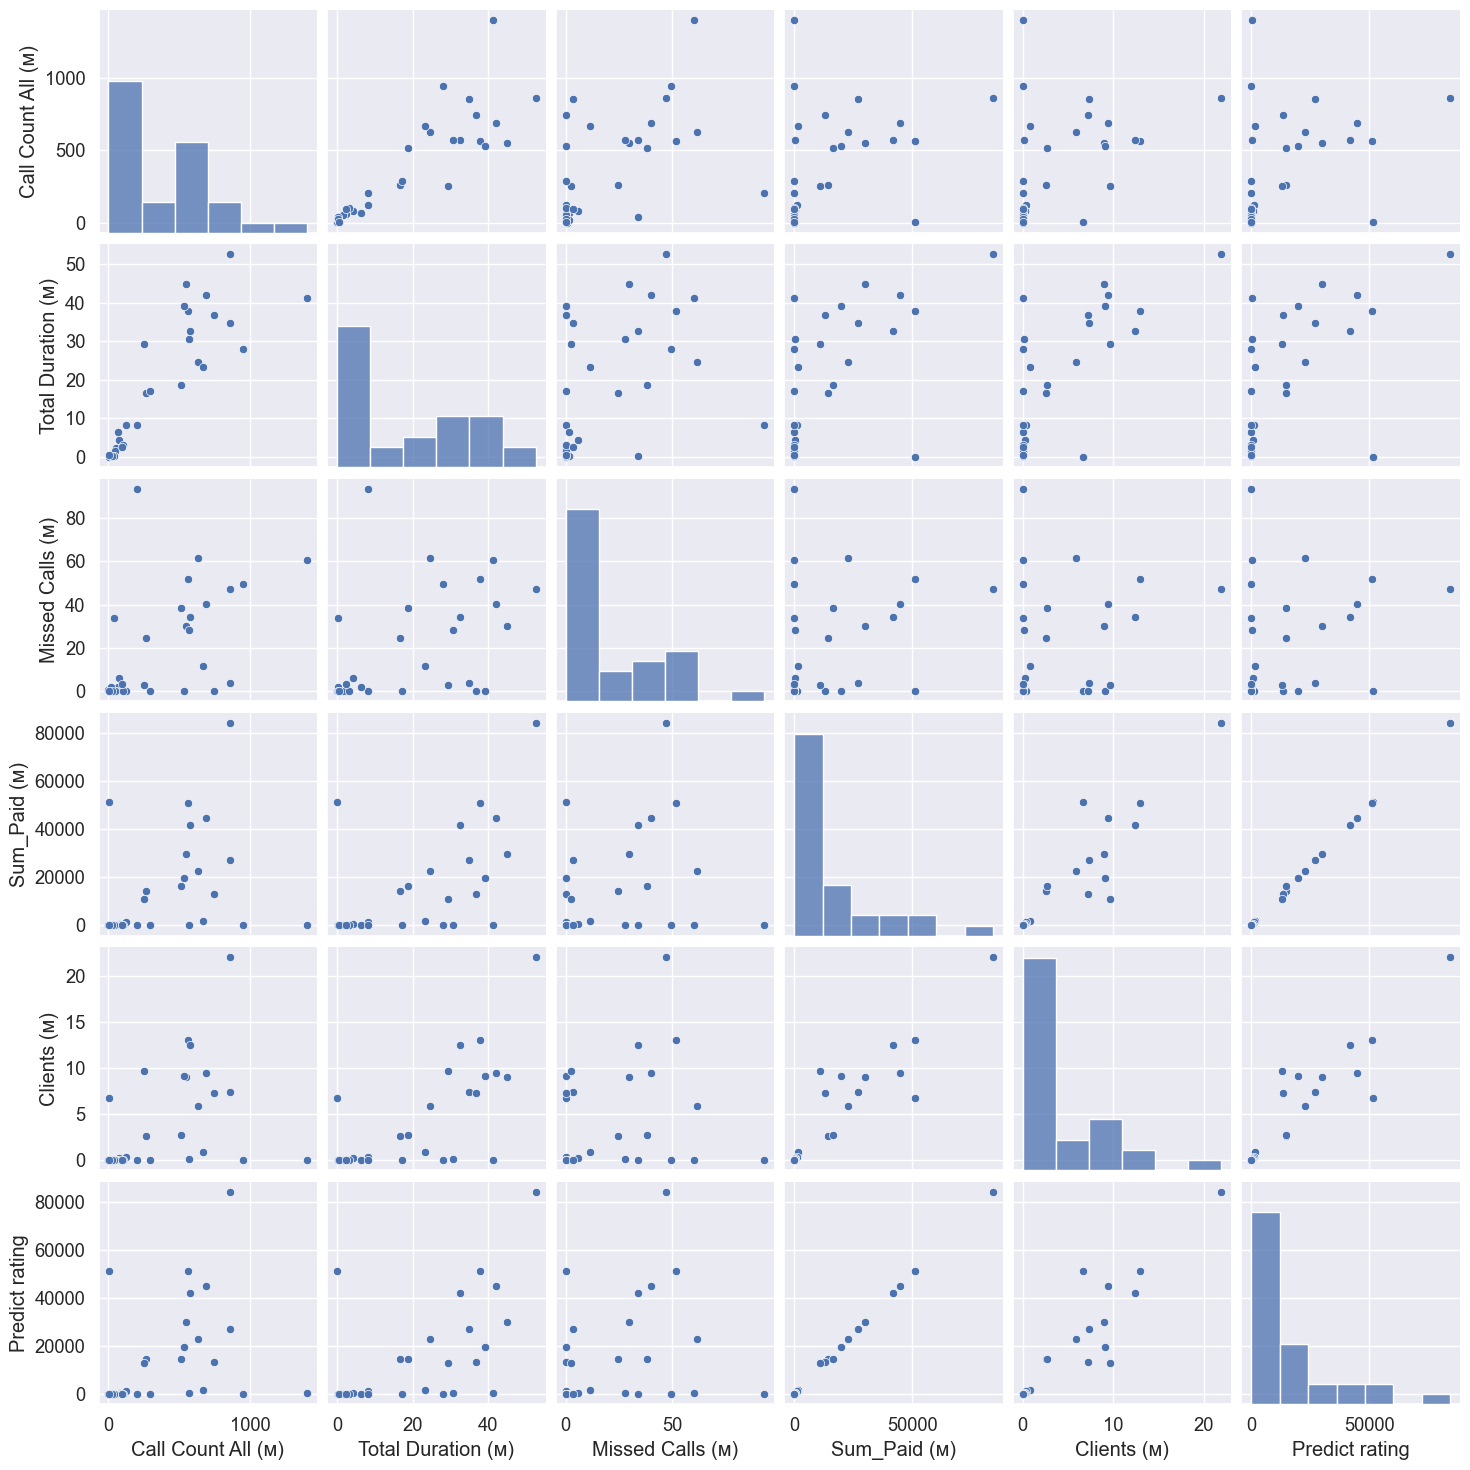

In [72]:
sns.pairplot(df_merged_sorted[['Call Count All (м)', 'Total Duration (м)', 'Missed Calls (м)', 'Sum_Paid (м)', 'Clients (м)', 'Predict rating']])
plt.show()

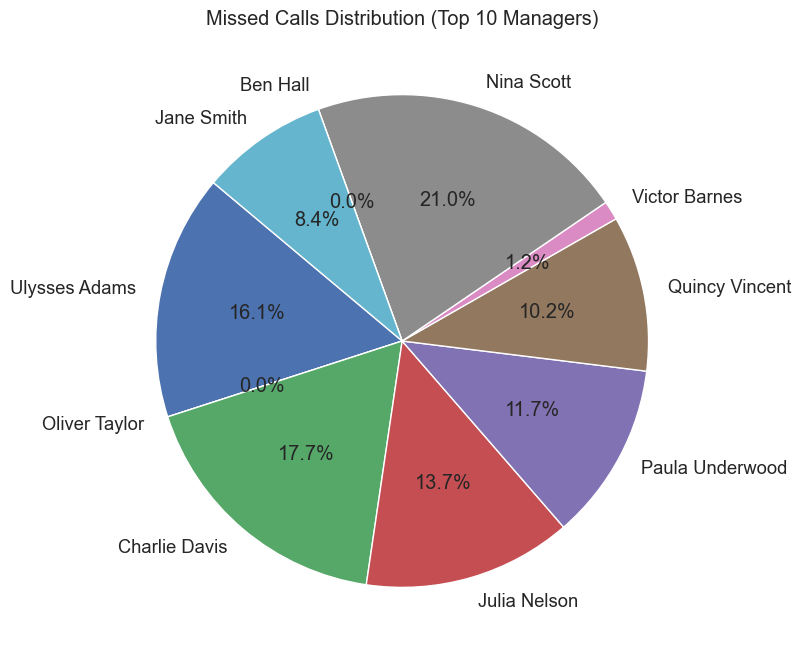

In [73]:
plt.figure(figsize=(8, 8))
df_merged_sorted_top10 = df_merged_sorted.head(10)
plt.pie(df_merged_sorted_top10['Missed Calls (м)'], labels=df_merged_sorted_top10['Call Owner Name'], autopct='%1.1f%%', startangle=140)
plt.title('Missed Calls Distribution (Top 10 Managers)')
plt.show()

## Conclusions
Ulysses Adams leads with the highest number of calls and the highest predicted rating, indicating his activity and engagement. Yara Edwards has the most calls; however, her predicted rating is lower, likely due to a high percentage of missed calls and errors. Eva Kent shows the worst performance among top managers in terms of call volume and has the lowest predicted rating. Amy Green and Hannah Lee demonstrate low ratings due to a high number of missed calls and errors, despite a large number of completed calls. Xander Dean ranks last with the least number of calls and the shortest call duration. The number of calls correlates with call duration and the number of clients, indicating the importance of manager activity in attracting and retaining clients. The sum of payments (Sum_Paid) has a strong correlation with the number of clients, showing that client conversion directly affects revenue. Amy Green, Bob Brown, and Rachel White have a high percentage of missed calls, which may negatively impact their work efficiency. Diana Evans shows a high number of lost clients, which requires special attention to improve service quality. Heatmaps show the concentration of manager activities at various stages of deals. Most issues are related to missed calls and lost leads. Leaders in activity, such as Charlie Davis and Julia Nelson, demonstrate a more balanced distribution across the stages of working with leads and clients. The pie chart shows that Yara Edwards and Charlie Davis have the highest percentage of missed calls among top managers. This could be a key point for optimizing their work. There is a dependency between the number of calls, the number of clients, and the number of errors. Correlation analysis shows that as the number of calls and clients increases for managers, so does the number of errors. This may indicate a problem with the distribution of workload among managers. Yara Edwards, Ulysses Adams, and Julia Nelson have a high level of activity (a large number of calls), but this is accompanied by an increase in errors, which may indicate overload for these managers. Charlie Davis and Ben Hall also demonstrate a high level of calls and a large number of errors, which may indicate inadequate training or excessive workload.

Conclusion: To improve performance, focus should be on reducing the number of missed calls and errors among certain managers, as well as enhancing the work of managers who show poor client conversion. It may be worthwhile to reconsider the distribution of calls among managers to prevent overload and improve the quality of their work. Optimizing the processes for distributing clients among managers could reduce the number of errors and increase overall efficiency.
If you need any adjustments or further translations, just let me know!

In [ ]:
# Filter the data based on the conditions: 'Payment Done', 'Months of study' > 0, and having 'Closing Date'
df_filtered = df_d[(df_d['Stage'] == 'Payment Done') & 
                   (df_d['Months of study'] > 0) & 
                   (df_d['Closing Date'].notna())].copy()

# Calculate the dropout month based on 'Closing Date' + 'Months of study'
df_filtered.loc[:, 'Dropout Month'] = (df_filtered['Closing Date'] + 
                                       pd.to_timedelta(df_filtered['Months of study'] * 30, unit='D')).dt.to_period('M')

# Add a "Cohort Month" column based on 'Closing Date'
df_filtered['Cohort Month'] = df_filtered['Closing Date'].dt.to_period('M')

# Check the result
df_filtered[['Created Time', 'Closing Date', 'Months of study', 'Cohort Month', 'Dropout Month']].head()

,Created Time,Closing Date,Months of study,Cohort Month,Dropout Month
468,2024-06-15 20:01:00,2024-06-18,1.0,2024-06,2024-07
478,2024-06-15 17:02:00,2024-06-19,1.0,2024-06,2024-07
1040,2024-06-10 15:33:00,2024-06-17,1.0,2024-06,2024-07
1282,2024-06-06 14:27:00,2024-06-07,1.0,2024-06,2024-07
1383,2024-06-05 10:41:00,2024-06-13,1.0,2024-06,2024-07


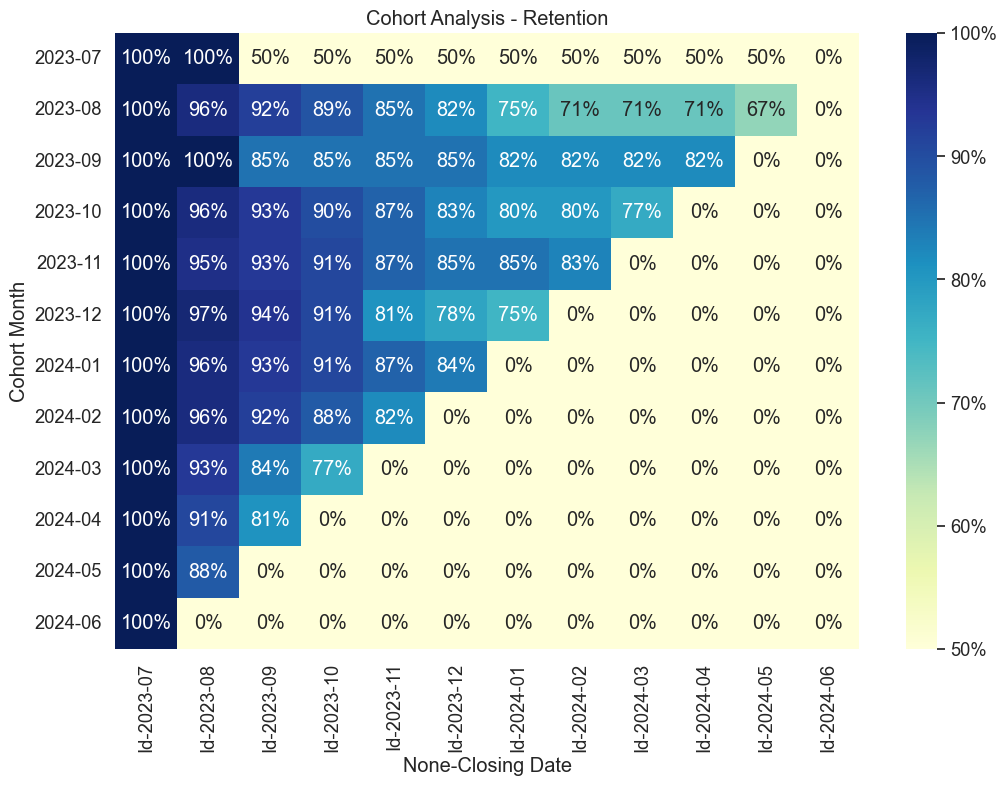

In [ ]:
# Grouping data by cohort month (Cohort Month) and closing month (Closing Date)
cohort_counts = df_filtered.groupby(['Cohort Month', df_filtered['Closing Date'].dt.to_period('M')]).agg({'Id': 'nunique'}).unstack(fill_value=0)

# Converting cohort months to cumulative form to accumulate students by month
cohort_cumulative = cohort_counts.cumsum(axis=1)

# Grouping data by cohort month and dropout month (Dropout Month)
dropout_counts = df_filtered.groupby(['Cohort Month', df_filtered['Dropout Month']]).agg({'Id': 'nunique'}).unstack(fill_value=0)

# Adjusting dropout_counts indices to match cohort_counts for correct subtraction
dropout_counts = dropout_counts.reindex_like(cohort_counts).fillna(0)

# Cumulative number of students by month (including dropouts)
dropout_cumulative = dropout_counts.cumsum(axis=1)

# Subtracting dropouts from the total in the cohort
final_cohort = cohort_cumulative - dropout_cumulative

# Filling possible NaN values with zeros after subtraction
final_cohort = final_cohort.fillna(0)

# Function to shift values to the left, considering zeros as empty values
def shift_left_to_zero(df):
    shifted_df = pd.DataFrame(index=df.index, columns=df.columns)  # Create a new table with the same indices and columns
    for i in range(len(df)):  # Loop through each row by index
        non_zero_values = df.iloc[i][df.iloc[i] != 0].values  # Get non-zero values in the row
        shifted_df.iloc[i, :len(non_zero_values)] = non_zero_values  # Shift non-zero values to the left
        shifted_df.iloc[i, len(non_zero_values):] = 0  # Fill the remaining part of the row with zeros
    return shifted_df

# Applying the shifting function to the final_cohort table
shifted_df = shift_left_to_zero(final_cohort)

# Function to convert the first column to 100%, and the other values to percentages
def convert_to_percentages_with_format(df):
    percent_df = df.copy()  # Create a copy of the table
    for i in range(len(df)):  # Loop through each row by index
        first_value = df.iloc[i, 0]  # Take the first value in the row
        if first_value != 0:  # Ensure that the value is not zero
            percent_df.iloc[i] = (df.iloc[i] / first_value) * 100  # Convert values to percentages
            percent_df.iloc[i, 0] = 100  # Set the first column as 100%
    # Convert values to percentages with rounding and add the '%' sign
    percent_df = percent_df.round(0).astype(int).astype(str) + '%'
    return percent_df

# Applying the function to the shifted table
formatted_percent_df = convert_to_percentages_with_format(shifted_df)

# Function to plot the heatmap
def plot_heatmap(df):
    # Ensure that the data is in numeric format
    numeric_df = df.copy()
    for col in numeric_df.columns:
        numeric_df[col] = pd.to_numeric(numeric_df[col].str.rstrip('%'), errors='coerce')  # Remove '%' sign before conversion

    # Plotting the heatmap with percentages
    plt.figure(figsize=(12, 8))
    sns.heatmap(numeric_df, annot=df.values, fmt='', cmap='YlGnBu', vmin=50, vmax=100, cbar_kws={'format': '%.0f%%'})
    
    plt.title('Cohort Analysis - Retention')
    plt.show()

# Applying the heatmap to the formatted table
plot_heatmap(formatted_percent_df)

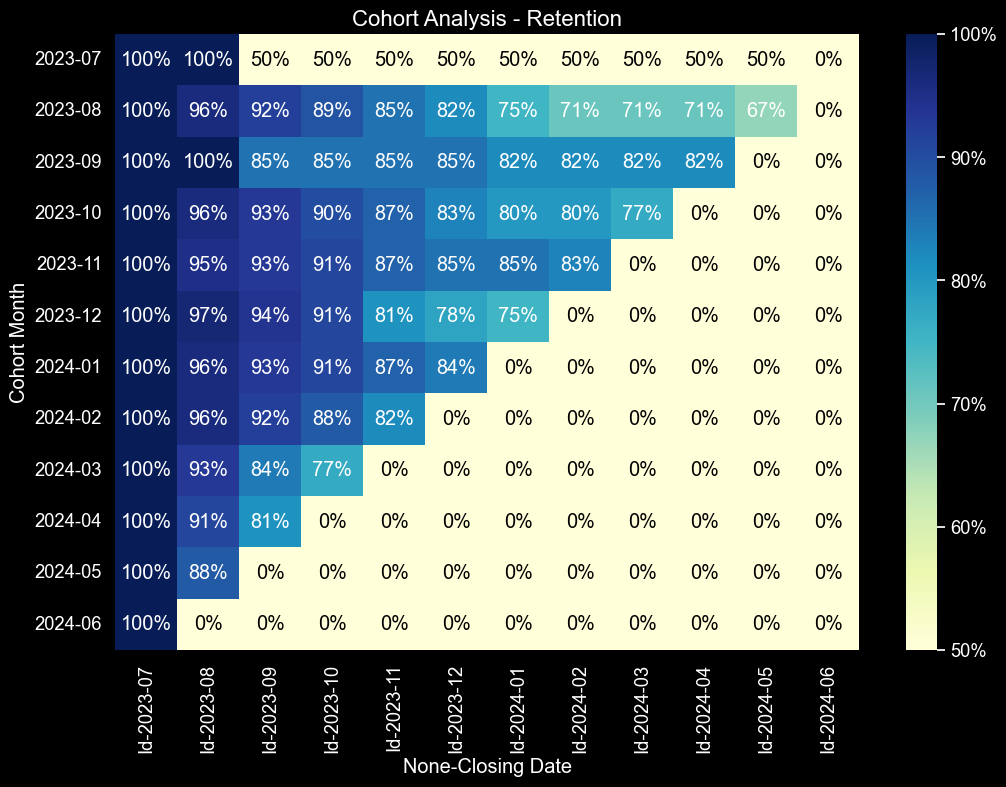

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Function to plot a heatmap with dynamic text color changes
def plot_heatmap_with_dynamic_text_color(df):
    # Ensure that the data is in numeric format
    numeric_df = df.copy()
    for col in numeric_df.columns:
        numeric_df[col] = pd.to_numeric(numeric_df[col].str.rstrip('%'), errors='coerce')  # Remove '%' sign before conversion

    # Plotting the heatmap with percentages
    plt.figure(figsize=(12, 8), facecolor='black')
    sns.set(font_scale=1.2)
    heatmap = sns.heatmap(numeric_df, annot=df.values, fmt='', cmap='YlGnBu', vmin=50, vmax=100, 
                          cbar_kws={'format': '%.0f%%'})

    # Apply dynamic text color changes
    for text in heatmap.texts:
        text_value = float(text.get_text().rstrip('%')) / 100  # Convert text value to percentage
        cmap = plt.get_cmap('YlGnBu')  # Get the colormap
        text_color = cmap(text_value)  # Get the color of the cell
        brightness = (text_color[0] * 299 + text_color[1] * 587 + text_color[2] * 114) / 1000  # Calculate brightness
        text.set_color('white' if brightness < 0.5 else 'black')  # If the background is dark — white text, if light — black

    # Adjust text color for the legend
    cbar = heatmap.collections[0].colorbar
    cbar.ax.yaxis.set_tick_params(color='white')  # Color of labels on the legend
    plt.setp(cbar.ax.yaxis.get_ticklabels(), color='white')  # Color of text on the legend

    # Adjust appearance of axes and titles
    heatmap.xaxis.label.set_color('white')
    heatmap.yaxis.label.set_color('white')
    heatmap.tick_params(colors='white')
    heatmap.title.set_color('white')
    
    plt.title('Cohort Analysis - Retention', color='white', fontsize=16)
    plt.show()

# Call the function with your DataFrame
plot_heatmap_with_dynamic_text_color(formatted_percent_df)

## Conclusions
Noticeable Drop in Customer Retention: Cohorts over time show a sharp decline in customer retention. For example, the cohort from July 2023 saw retention drop from 100% to 50% within just a few months, stabilizing afterward. Other cohorts, such as those from August and September 2023, exhibit similar patterns, where customer retention decreases to 67% and 82%, respectively, after several months.

Cohorts from the End of 2023 (September – December): Retention for these cohorts shows somewhat more stable metrics compared to earlier months. However, by the end of the observation period, each cohort reaches 0% retention, indicating that all customers have stopped returning.

Retention Issues in Early 2024: Cohorts from January, February, and March 2024 demonstrate particularly low retention rates. Retention drops sharply to 0% within a few months after the first interaction, which requires attention. Cohorts from April 2024 and beyond also show negative trends, with a complete absence of customer retention in subsequent months.

Overall Trend: Regardless of the starting month, cohorts consistently lose customers 3-4 months after initiation. This may indicate a need to revise customer engagement and retention strategies. Potential solutions could involve enhancing post-sales support or initiating additional measures to boost customer loyalty a few months after the first transaction.

Focus on Improving Retention: There is a need to focus on retaining customers in the first 2-3 months, as most cohorts lose a significant portion of customers during this period. This may require developing new loyalty programs, bonuses, or improved conditions for repeat transactions, especially in the months following customer acquisition.

In summary, cohort analysis reveals an urgent need for measures to improve customer retention and prevent rapid customer churn after the initial months. It is recommended to reconsider the program for follow-up calls with lost customers to enhance the quality of the materials provided. Additionally, it may be worthwhile to reduce the workload or extend the study time, which could increase profitability per month of study and decrease customer churn.